In [1]:
import COVID19Py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
from datetime import datetime
from datetime import timedelta  

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import operator

In [2]:
covid19 = COVID19Py.COVID19()

In [64]:
latest = covid19.getLatest()
latest

{'confirmed': 529591, 'deaths': 23970, 'recovered': 0}

In [4]:
def normatize_cases_by_absolute_day(df):
    
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    current_day = 0
    
    for i in range(df.shape[0]):
        if df.iloc[i].Cases > 0:
            current_day = current_day+1
            days.append(current_day)
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%dT%H:%M:%SZ')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df

def contagious_dataframe(df):
    contagious_list = []
    for x in range(df.shape[0]):
        if x == 0:
            contagious_list.append(0)
        if (x+1) < df.shape[0]:
            cases_sub = df.iloc[(x+1)].Cases - df.iloc[x].Cases
            contagious_list.append(cases_sub)
    df = pd.DataFrame({'Contagious': contagious_list})
    return df 

def data_consolidation(data):
    
    confirmed_dict = {}
    deaths_dict = {}
    recovered_dict = {}
    
    for i in range(len(data)):
        confirmed = data[i]['timelines']['confirmed']['timeline']
        deaths = data[i]['timelines']['deaths']['timeline']
        recovered = data[i]['timelines']['recovered']['timeline']
        for key in confirmed:
            if i == 0:
                confirmed_dict[key] = confirmed[key]
            else:
                confirmed_dict[key] = confirmed_dict[key]+confirmed[key]
        for key in deaths:
            if i == 0:
                deaths_dict[key] = deaths[key]
            else:
                deaths_dict[key] = deaths_dict[key]+deaths[key]
        for key in recovered:
            if i == 0:
                recovered_dict[key] = recovered[key]
            else:
                recovered_dict[key] = recovered_dict[key]+recovered[key]
                
    return confirmed_dict, deaths_dict, recovered_dict
            

In [5]:
no_catalog_cases_china = pd.read_csv(r'china_no_catalog_cases.csv', delimiter=";", header=None)
no_catalog_cases_china.columns = ['Date', 'Cases']

no_catalog_cases_china_deaths_recovered = pd.read_csv(r'china_no_catalog_cases_deaths_recovered.csv', delimiter=";", header=None)
no_catalog_cases_china_deaths_recovered.columns = ['Date', 'Cases']

In [6]:
brazil_confirmed_dict, brazil_deaths_dict, brazil_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("BR", timelines=True))
japan_confirmed_dict, japan_deaths_dict, japan_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("JP", timelines=True))
china_confirmed_dict, china_deaths_dict, china_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("CN", timelines=True))
south_korea_confirmed_dict, south_korea_deaths_dict, south_korea_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("KR", timelines=True))
italy_confirmed_dict, italy_deaths_dict, italy_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("IT", timelines=True))
us_confirmed_dict, us_deaths_dict, us_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("US", timelines=True))


dfBrazilConfirmedRaw = pd.DataFrame(brazil_confirmed_dict.items(), columns=['Date', 'Cases'])
dfJapanConfirmedRaw = pd.DataFrame(japan_confirmed_dict.items(), columns=['Date', 'Cases'])
dfChinaConfirmedRaw = pd.DataFrame(china_confirmed_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaConfirmedRaw = pd.DataFrame(south_korea_confirmed_dict.items(), columns=['Date', 'Cases'])
dfItalyConfirmedRaw = pd.DataFrame(italy_confirmed_dict.items(), columns=['Date', 'Cases'])
dfUsConfirmedRaw = pd.DataFrame(us_confirmed_dict.items(), columns=['Date', 'Cases'])

dfBrazilDeathsRaw = pd.DataFrame(brazil_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanDeathsRaw = pd.DataFrame(japan_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaDeathsRaw = pd.DataFrame(china_deaths_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaDeathsRaw = pd.DataFrame(south_korea_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyDeathsRaw = pd.DataFrame(italy_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfUsDeathsRaw = pd.DataFrame(us_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)

dfBrazilRecoveredRaw = pd.DataFrame(brazil_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanRecoveredRaw = pd.DataFrame(japan_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.DataFrame(china_recovered_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaRecoveredRaw = pd.DataFrame(south_korea_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyRecoveredRaw = pd.DataFrame(italy_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfUsRecoveredRaw = pd.DataFrame(us_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)


dfChinaConfirmedRaw = pd.concat([no_catalog_cases_china, dfChinaConfirmedRaw], ignore_index=True)
dfChinaDeathsRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaDeathsRaw], ignore_index=True).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaRecoveredRaw], ignore_index=True).drop(["Date"], axis=1)


dfBrazilContagiousRaw = contagious_dataframe(dfBrazilConfirmedRaw)
dfJapanContagiousRaw = contagious_dataframe(dfJapanConfirmedRaw)
dfChinaContagiousRaw = contagious_dataframe(dfChinaConfirmedRaw)
dfSouthKoreaContagiousRaw = contagious_dataframe(dfSouthKoreaConfirmedRaw)
dfItalyContagiousRaw = contagious_dataframe(dfItalyConfirmedRaw)
dfUsContagiousRaw = contagious_dataframe(dfUsConfirmedRaw)

In [7]:
dfBrazilRaw = pd.concat(
    [dfBrazilConfirmedRaw,dfBrazilDeathsRaw, dfBrazilRecoveredRaw, dfBrazilContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfJapanRaw = pd.concat(
    [dfJapanConfirmedRaw,dfJapanDeathsRaw, dfJapanRecoveredRaw, dfJapanContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfChinaRaw = pd.concat(
    [dfChinaConfirmedRaw,dfChinaDeathsRaw, dfChinaRecoveredRaw, dfChinaContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfSouthKoreaRaw = pd.concat(
    [dfSouthKoreaConfirmedRaw,dfSouthKoreaDeathsRaw, dfSouthKoreaRecoveredRaw, dfSouthKoreaContagiousRaw], 
    ignore_index=True, 
    axis=1
)

dfItalyRaw = pd.concat(
    [dfItalyConfirmedRaw,dfItalyDeathsRaw, dfItalyRecoveredRaw, dfItalyContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfUsRaw = pd.concat(
    [dfUsConfirmedRaw,dfUsDeathsRaw, dfUsRecoveredRaw, dfUsContagiousRaw], 
    ignore_index=True, 
    axis=1
)

dfBrazilRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfJapanRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfChinaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfSouthKoreaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfItalyRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfUsRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']


In [8]:
dfBrazil = normatize_cases_by_absolute_day(dfBrazilRaw)
dfJapan = normatize_cases_by_absolute_day(dfJapanRaw)
dfChina = normatize_cases_by_absolute_day(dfChinaRaw)
dfSouthKorea = normatize_cases_by_absolute_day(dfSouthKoreaRaw)
dfItaly = normatize_cases_by_absolute_day(dfItalyRaw)
dfUs = normatize_cases_by_absolute_day(dfUsRaw)

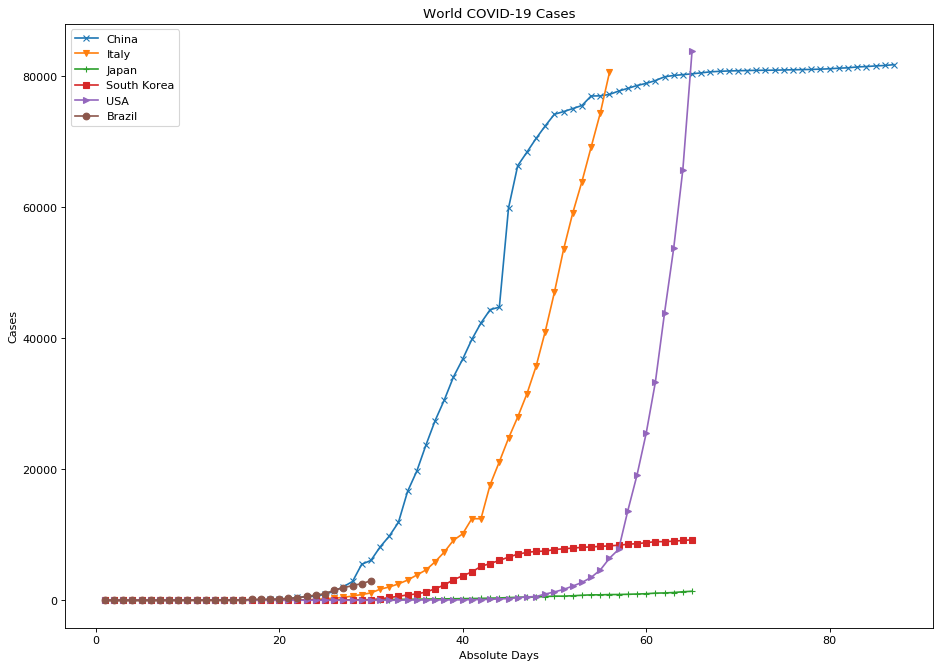

In [9]:
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Cases, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Cases, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Cases, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Cases, "-s", label="South Korea")
plt.plot(dfUs.Day, dfUs.Cases, "->", label="USA")
plt.plot(dfBrazil.Day, dfBrazil.Cases, "-o", label="Brazil")
plt.title("World COVID-19 Cases")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()

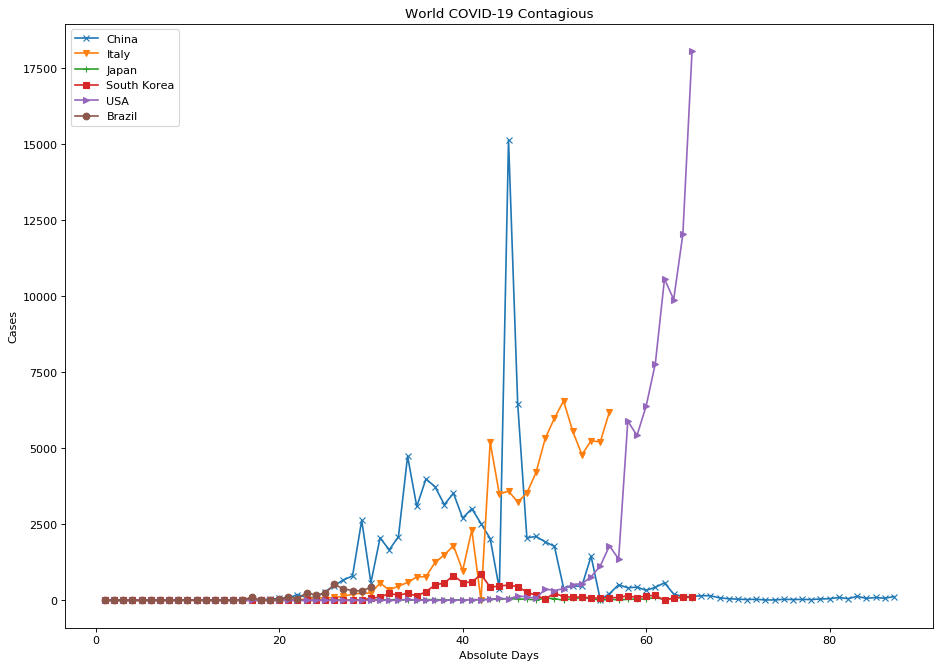

In [10]:
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Contagious, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Contagious, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Contagious, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Contagious, "-s", label="South Korea")
plt.plot(dfUs.Day, dfUs.Contagious, "->", label="USA")
plt.plot(dfBrazil.Day, dfBrazil.Contagious, "-o", label="Brazil")
plt.title("World COVID-19 Contagious")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()

In [11]:
def calc_stable_day(df):
    df = contagious_dataframe(df)
    
    percentualContagious = []
    stable_final_day = None
    flag_break_stable_day = 0
    stable_final_day = None
    
    for x in range(df.shape[0]):
        percentual_day = (df.iloc[x].Contagious*100)/df.max().Contagious
        percentualContagious.append(percentual_day)
    
    
    for i in range(len(percentualContagious)):
        if int(percentualContagious[i]) == 100:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 1 and int(percentualContagious[i]) == 0:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 2:
            stable_final_day = i+1
            break
    
    
    return stable_final_day

In [69]:
days_to_stable_day = int(calc_stable_day(dfChina)+(calc_stable_day(dfChina)*0.3))

In [13]:
def normatization_for_stable_days(df, stable_total_days):
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    for i in range(stable_total_days):
        days.append(i+1)
        if i < df.shape[0]:
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%d %H:%M:%S')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
            last_date = datetime_object
        else:
            last_date = (last_date+timedelta(days=1))
            cases.append(None)
            dates.append(last_date)
            deaths.append(None)
            recovereds.append(None)
            contagious.append(None)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df
    

In [71]:
dfNormDaysBrazil = normatization_for_stable_days(dfBrazil, days_to_stable_day)

In [15]:
dfNormDaysBrazil.to_csv(r'brazil_data.csv', index=False)

In [16]:
dfChina.to_csv(r'china_data.csv', index=False)
dfJapan.to_csv(r'japan_data.csv', index=False)
dfSouthKorea.to_csv(r'south_korea_data.csv', index=False)
dfItaly.to_csv(r'italy_data.csv', index=False)
dfUs.to_csv(r'us_data.csv', index=False)

In [17]:
X = dfChina.drop(["Cases","Date","Recovered","Deaths","Contagious"], axis=1).values.reshape(-1, 1)
y = dfChina.Cases

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.0)

In [61]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X, y)

clf = DecisionTreeClassifier()
clf = clf.fit(X,y)

polynomial_features= PolynomialFeatures(degree=8, include_bias=False)
X_poly = polynomial_features.fit_transform(X)

poly_model = LinearRegression().fit(X_poly, y)


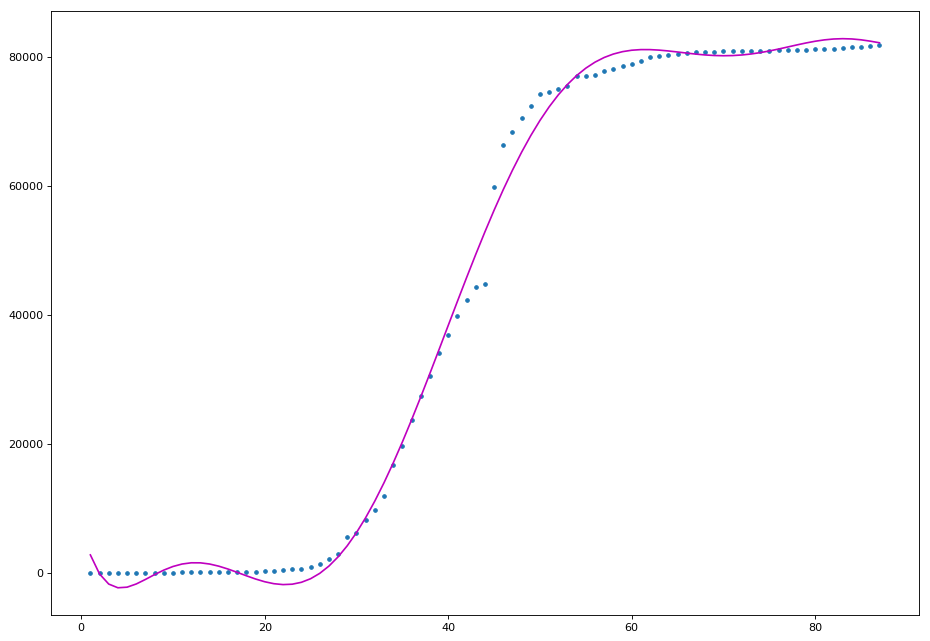

In [62]:
y_poly_pred = poly_model.predict(X_poly)
rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
r2 = r2_score(y_train,y_poly_pred)

plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X, y, s=10)
plt.plot(X, y_poly_pred, color='m')
plt.show()

In [63]:
y_poly_pred

array([ 2.76129066e+03, -1.95624497e+02, -1.76149878e+03, -2.33624140e+03,
       -2.24500141e+03, -1.74729274e+03, -1.04539317e+03, -2.92052078e+02,
        4.02458735e+02,  9.63917890e+02,  1.34831819e+03,  1.53658958e+03,
        1.52985023e+03,  1.34515547e+03,  1.01171515e+03,  5.67550753e+02,
        5.65643159e+01, -4.74007919e+02, -9.75783426e+02, -1.40108846e+03,
       -1.70450498e+03, -1.84413345e+03, -1.78259462e+03, -1.48779278e+03,
       -9.33461939e+02, -9.95159587e+01,  1.02777750e+03,  2.45577989e+03,
        4.18560309e+03,  6.21235141e+03,  8.52546752e+03,  1.11091660e+04,
        1.39429394e+04,  1.70021220e+04,  2.02584981e+04,  2.36809405e+04,
        2.72360696e+04,  3.08889183e+04,  3.46035950e+04,  3.83439334e+04,
        4.20741206e+04,  4.57592946e+04,  4.93661050e+04,  5.28632285e+04,
        5.62218350e+04,  5.94159982e+04,  6.24230462e+04,  6.52238496e+04,
        6.78030433e+04,  7.01491807e+04,  7.22548188e+04,  7.41165337e+04,
        7.57348673e+04,  